In [1]:
from extract_lidar_features import *
from visualization_lidar import *
from load_lidar_data import *

In [2]:
downsample_factor = 4
threshold = 10
transform_method = "normalization_without_mask"

# Load data to numpy array
lidar_data, selected_list = load_lidar_data(num_images=20, input_h=1280, input_w=1920, downsample=downsample_factor)
# Convert the data to the Dataset class
lidar_data = ProjectedLidarDataset(lidar_data, downsample=downsample_factor, transform_method=transform_method, threshold=threshold)


# Calculate the input size
num_samples, height, width = lidar_data.shape

# Create dataloader
train_data_loader = create_dataloader(input_lidar=lidar_data, batch_size=4)

print(selected_list)

Elapsed time to load the lidar data:  2.396453857421875
['/home/meowater/Documents/ssd_drive/lidar_projected/9820553434532681355_2820_000_2840_000/9820553434532681355_2820_000_2840_000_camera_image_camera_1_timestamp-1557336869948835.pkl', '/home/meowater/Documents/ssd_drive/lidar_projected/10923963890428322967_1445_000_1465_000/10923963890428322967_1445_000_1465_000_camera_image_camera_1_timestamp-1522784924795768.pkl', '/home/meowater/Documents/ssd_drive/lidar_projected/3385534893506316900_4252_000_4272_000/3385534893506316900_4252_000_4272_000_camera_image_camera_1_timestamp-1518657353939997.pkl', '/home/meowater/Documents/ssd_drive/lidar_projected/2088865281951278665_4460_000_4480_000/2088865281951278665_4460_000_4480_000_camera_image_camera_1_timestamp-1553535070889592.pkl', '/home/meowater/Documents/ssd_drive/lidar_projected/4487677815262010875_4940_000_4960_000/4487677815262010875_4940_000_4960_000_camera_image_camera_1_timestamp-1557326019147056.pkl', '/home/meowater/Documents/

In [3]:

model_path = '/home/meowater/Documents/ssd_drive/CAE_models/lidar_data_cae_model.pkl'

with open(model_path, 'rb') as f:
    model, _ = pickle.load(f)



In [ ]:
model, losses = cae_train(train_data_loader, epochs=250, lr=0.00001)

In [ ]:
visualize_cae_result(model, lidar_data, recon_height=height, recon_width=width, num_images2show=6, device=device)


In [ ]:
test_data = load_lidar_data(num_images=6, input_h=1280, input_w=1920, downsample=downsample_factor)
visualize_cae_result(model, test_data, recon_height=height, recon_width=width, num_images2show=6, device=device)

In [ ]:
test_data

In [ ]:
# save_path = '/home/meowater/Documents/ssd_drive/CAE_models/'
# os.makedirs(save_path, exist_ok=True)
#
# output_fn = os.path.join(save_path, 'lidar_data_cae_model_resized.pkl')
# with open(output_fn, 'wb') as handle:
#     pickle.dump((model, losses), handle, protocol=pickle.HIGHEST_PROTOCOL)

model_path = '/home/meowater/Documents/ssd_drive/CAE_models/lidar_data_cae_model.pkl'

with open(model_path, 'rb') as f:
    model, _ = pickle.load(f)

In [ ]:
def output_cae_encoded(input_lidar, cae_model):
    cae_model.eval()
    with torch.no_grad():
        x = torch.FloatTensor(input_lidar).to(device)
        reshaped_x = x.unsqueeze(0)
        reshaped_x = reshaped_x.unsqueeze(0)
        encoded= cae_model.encode(reshaped_x)

        encoded = encoded.squeeze(0).cpu().numpy()
    return encoded

In [ ]:

# Go through all lidar data
lidar_path = '/home/meowater/Documents/ssd_drive/lidar_projected/'
save_path = '/home/meowater/Documents/ssd_drive/lidar_projected_cae_resized/'

lidar_list = glob.glob(os.path.join(lidar_path, '*/*.pkl'), recursive=True)

for ind, fn in enumerate(lidar_list):

    _, base_name = os.path.split(fn)
    name_prefix = base_name.split('.')[0]
    context_name = name_prefix.split('_camera_image_camera')[0]
    timestamp_name = name_prefix.split('_timestamp-')[-1]

    sub_path = os.path.join(save_path, context_name)

    new_fn = os.path.join(sub_path, name_prefix + '_cae_feature.pkl')

    if os.path.isfile(new_fn):
        # pass if the file already exists
        continue
    else:
        os.makedirs(sub_path, exist_ok=True)
        with open(fn, 'rb') as handle:
            data = pickle.load(handle)

        projected_lidar = resize(data["lidar_projection"],
                                      output_shape=(height.cpu().numpy(), width.cpu().numpy()),
                                      anti_aliasing=True)

        output = output_cae_encoded(projected_lidar, model)



        output_data = {
            "context_name": context_name,
            "timestamp": timestamp_name,
            "lidar_extracted": output
        }


        with open(new_fn, 'wb') as handle:
            pickle.dump(output_data, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
print(len(lidar_list))

process_list = glob.glob(os.path.join(save_path, '*/*.pkl'), recursive=True)
print(len(process_list))

In [ ]:
search_path = '/home/meowater/Desktop/training/lidar/'
file_list = glob.glob(search_path + '*.parquet')
print(len(file_list))

Reconstructed shape is torch.Size([1, 1, 320, 320])
Reconstructed shape after squeeze is torch.Size([1, 320, 320])
/home/meowater/Documents/ssd_drive/compressed_camera_images2/9820553434532681355_2820_000_2840_000/camera_image_camera-1_timestamp-1557336869948835.jpg


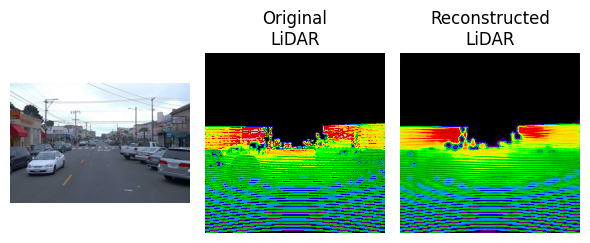

Reconstructed shape is torch.Size([1, 1, 320, 320])
Reconstructed shape after squeeze is torch.Size([1, 320, 320])
/home/meowater/Documents/ssd_drive/compressed_camera_images2/10923963890428322967_1445_000_1465_000/camera_image_camera-1_timestamp-1522784924795768.jpg


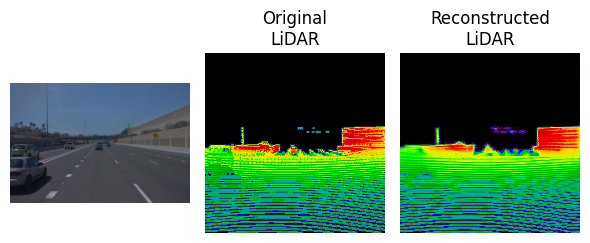

In [4]:

for ind in range(2):
    input_data = lidar_data[ind].unsqueeze(0)
    visualize_cae_result_with_image(model, input_data, selected_list[ind], recon_height=height, recon_width=width)


In [ ]:
from PIL import Image

test = Image.open('/home/meowater/Documents/ssd_drive/compressed_camera_images2/17642771458376274038_2080_000_2100_000/camera_image_camera-1_timestamp-1547741665438923.jpg')
print(test.size)
test.show()